In [1]:
from build_model_and_dataset import *

After layer 1 : x.shape=torch.Size([1, 1])
After layer 2 : x.shape=torch.Size([1, 1])
After layer 3 : x.shape=torch.Size([1, 10])
Time to build the model: 0.04 seconds


In [2]:
MLP_model.skeleton, MLP_model.count_parameters()

({0: {'size': 50}, 1: {'size': 1}, 2: {'size': 1}, 3: {'size': 10}}, 73)

In [3]:
expe = str(2)


In [4]:
name_file_expe = 'results/StrategyOnEigenValue/' + expe + '/'
os.mkdir(name_file_expe)

In [5]:
to_add = [1, 2] # depths where we want to add neurons
nbr_steps_betw_adding = 0 # number of gradient step between each architecture growth

In [6]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])

In [7]:
def update_quantity_of_interest(method = 'Add', depth = 1) :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    X, Y = MLP_model.get_batch(indices=torch.arange(MLP_model.len_train_dataset))
    dico_DV = {'DV_norm_' + str(d) : np.sqrt((MLP_model.deplacement_voulu(d, X=X, Y = Y).norm()**2 / X.shape[0]).item()) for d in [1, 2, 3]}
    
    if method == 'Add' :
        #DV = MLP_model.deplacement_voulu(depth, X=X, Y = Y)
        dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
        dico_tracker.update({'depth_add' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'sum_vps_sq' : (MLP_model.valeurs_propres ** 2).sum().item(),
                        'count': count, 'DV_proj_norm_sq': MLP_model.DV_proj_norm_sq.item()})

    elif method == 'NG' : 
        #DV = MLP_model.deplacement_voulu(depth + 1, X=X, Y = Y)
        dico_tracker = {}
        dico_tracker.update({'depth_NG' : depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron,
                        'count': count})
    else:
        assert False
        
    dico_tracker.update({
        #'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv],
                        'size_layer_1' : [MLP_model.skeleton[1]['size']], 'size_layer_2' : [MLP_model.skeleton[2]['size']]})
    dico_tracker.update(dico_DV)
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr.unsqueeze(0)])
    L_te = np.concatenate([L_te, l_te.unsqueeze(0)])
    A_tr = np.concatenate([A_tr, a_tr.unsqueeze(0)])
    A_te = np.concatenate([A_te, a_te.unsqueeze(0)])
    #T = np.concatenate([T, t.unsqueeze(0) +  T[-1]])
    T = np.zeros(L_tr.shape[0] +1)
    
    
def AugBatchSizeLearning() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [8]:
def compute_Loss_full(model):
    """
    Computes the avearged and individual losses of the network for a minibatch 
    either when adding the BestUpdate or the Newneurons, 
    with the amplitude factor 'ampl_fact'.
    """
    indx = torch.arange(model.len_train_dataset)
    L_tr = torch.tensor(0., device = my_device)
    A_tr = torch.tensor(0., device = my_device)
    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0)
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_tr += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_tr += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]

    indx = torch.arange(model.len_test_dataset)
    L_te = torch.tensor(0., device = my_device)
    A_te = torch.tensor(0., device = my_device)

    for sous_indices in range(math.ceil(indx.shape[0]/model.max_batch_estimation)) :
        sous_ind = indx[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        sous_seed = model.seed_lmbda[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation]
        X, Y = model.get_batch(indices = sous_ind, seed = sous_seed[0], device = my_device_0, data = 'te')
        #l[sous_indices * model.max_batch_estimation : (sous_indices + 1) * model.max_batch_estimation] = model.Loss(fct_to_apply(X, depth = depth, lmbda = ampl_fact)[0], Y.to(my_device), reduction = 'none')
        with torch.no_grad() :
            Y_pred = model(X)
        L_te += model.Loss(Y_pred, Y, reduction = 'sum') /  indx.shape[0]
        A_te += UTILS.calculate_accuracy(Y_pred, Y) * sous_ind.shape[0] / indx.shape[0]
    return(L_tr, L_te, A_tr, A_te) 

In [9]:
def batch_size_estimation() :
    
    size_batch = MLP_model.len_train_dataset
    size_batch = int(size_batch)
    if MLP_model.force_small_estimation_batch or MLP_model.architecture_growth == 'Random' :
        size_batch = 100

    l = math.ceil(size_batch / MLP_model.max_batch_estimation) * MLP_model.max_batch_estimation

    if not (getattr(MLP_model, 'tr_loader', None) is None):
        max_len_l = max(MLP_model.len_train_dataset, l)
    else:
        max_len_l = l

    if not (getattr(MLP_model, 'tr_loader', None) is None):
        max_len_l = min(MLP_model.len_train_dataset, l)
    else:
        max_len_l = max(MLP_model.len_train_dataset, l)

    MLP_model.ind = torch.randperm(MLP_model.len_train_dataset)[:l]
    MLP_model.seed = torch.randperm(MLP_model.len_train_dataset)[:l]
    MLP_model.ind_lmbda = torch.randperm(MLP_model.len_train_dataset)[:MLP_model.ind_lmbda_shape]
    MLP_model.seed_lmbda = torch.randperm(MLP_model.len_train_dataset)[:MLP_model.ind_lmbda_shape]

In [10]:
count = 1
t_0, t = 0, 0

In [11]:
for j in tqdm(range(200)) :
    dico_vps = {d : 0. for d in to_add}
    for k in range(len(to_add)) :
        nbr_parameters_avant = MLP_model.count_parameters()
        depth = to_add[k]
        MLP_model.dico_w = None
        batch_size_estimation()
        EB.compute_optimal_update(MLP_model, depth + 1, update = False, compute_gain=False)
        batch_size_estimation()
        EB.add_neurons(MLP_model, depth, update = False, compute_gain=False)
        dico_vps[depth] = MLP_model.valeurs_propres_computed[0].item()
    print('dico_vps :', dico_vps)
    depth_star = list(dico_vps.keys())[np.argmax(list(dico_vps.values()))]
    MLP_model.dico_w = None
    EB.compute_optimal_update(MLP_model, depth_star + 1, update = False, compute_gain=False)
    EB.add_neurons(MLP_model, depth_star, update = True, compute_gain=True)
    l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
    update_quantity_of_interest(method = 'Add', depth = depth_star)
    
    for depth in range(1, 4) :
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        MLP_model.dico_w = None
        batch_size_estimation()
        EB.compute_optimal_update(MLP_model, depth, update = True)

        l_tr, l_te, a_tr, a_te = compute_Loss_full(MLP_model)
        t = torch.tensor(time.time() - t_0, device = my_device)
        update_quantity_of_interest(method = 'NG', depth = depth)

    count += 1
        
        
    
    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))




  0%|          | 0/200 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.15579691529273987, 2: 0.00322635006159544}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.6473617553710938
norm_x_over_norm_DE_depthp1 :  2.553107261657715
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.025604248046875, -0.03670167922973633, -0.03246665000915527]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.25, 0.5, 1.0]
rate of decrease : 0.015127476304769516 a



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0027801990509033203, -0.0043261051177978516, -0.003710031509399414]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.002017160877585411 ampli_fct : 0.0625 L[0] : 2.144650459289551
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0005762577056884766, -0.00069427490234375, 0.00016021728515625]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.00032437840127386153 ampli_fct : 0.0625 L[0] : 2.140324115753174
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize Be

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0011799335479736328, -0.0013475418090820312, 0.0008995532989501953]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.0006591873825527728 ampli_fct : 0.0625 L[0] : 2.0442469120025635
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.00452113151550293, -0.0065386295318603516, -0.003021240234375]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0625, 0.125, 0.25]
rate of decrease : 0.003200661623850465 ampli_fct : 0.125 L[0] : 2.0428993701934814
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.0666966363787651, 2: 0.039336711168289185}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 3.892205238342285
norm_x_over_norm_DE_depthp1 :  16.147741317749023
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.00207674503326416, -0.003137350082397461, -0.0026092529296875]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.0015



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.004973292350769043, -0.006170868873596191, 0.0006002187728881836]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0032908464781939983 ampli_fct : 0.03125 L[0] : 1.8751615285873413
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0022829771041870117, -0.0027074813842773438, 0.0013161897659301758]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.0014486328000202775 ampli_fct : 0.0625 L[0] : 1.8689907789230347
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** norm

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0015833377838134766, -0.002390146255493164, -0.001840353012084961]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0013427289668470621 ampli_fct : 0.03125 L[0] : 1.7800661325454712
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.000677943229675293, -0.0010035037994384766, -0.0006053447723388672]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0005645031342282891 ampli_fct : 0.03125 L[0] : 1.7776762247085571
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** 



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.08724740892648697, 2: 0.05525610223412514}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 3.8719136714935303
norm_x_over_norm_DE_depthp1 :  15.431487083435059
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.1920928955078125e-07, 1.1920928955078125e-07]  ... [-0.0017036199569702148, -0.001825571060180664, 0.0017474889755249023]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625,



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.002187490463256836, -0.0030536651611328125, -0.0014634132385253906]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.0018316393252462149 ampli_fct : 0.001953125 L[0] : 1.6671760082244873
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0018295049667358398, -0.0028219223022460938, -0.002440333366394043]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0016957421321421862 ampli_fct : 0.03125 L[0] : 1.6641223430633545
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO 

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.003797769546508789, -0.005904674530029297, -0.005619406700134277]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0036361513193696737 ampli_fct : 0.03125 L[0] : 1.6238802671432495
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0007697343826293945, -0.0011856555938720703, -0.000984787940979004]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0007328019710257649 ampli_fct : 0.03125 L[0] : 1.6179754734039307
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** s



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.07596410065889359, 2: 0.042232055217027664}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 4.053835868835449
norm_x_over_norm_DE_depthp1 :  17.99079704284668
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0007780790328979492, -0.0011180639266967773, -0.0008755922317504883]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decre



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 1.1920928955078125e-07, 0.0]  ... [-0.004555344581604004, -0.006246089935302734, -0.002359151840209961]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.004045565612614155 ampli_fct : 0.00390625 L[0] : 1.543934941291809
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.00555574893951416, -0.008695244789123535, -0.00810706615447998]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.00565474946051836 ampli_fct : 0.03125 L[0] : 1.5376887321472168
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG 

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.004269957542419434, -0.005740761756896973, 9.357929229736328e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.00383890513330698 ampli_fct : 0.03125 L[0] : 1.4954164028167725
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0009452104568481445, -0.0011219978332519531, 0.000786900520324707]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0007531826267950237 ampli_fct : 0.03125 L[0] : 1.4896756410598755
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0010946989059448242, -0.0014954805374145508, -0.0002281665802001953]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0010307369520887733 ampli_fct : 0.03125 L[0] : 1.4508846998214722
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.07766839116811752, 2: 0.05709201470017433}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize 



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, 0.0]  ... [-0.004180908203125, -0.006014108657836914, -0.0035941600799560547]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.004264972172677517 ampli_fct : 0.001953125 L[0] : 1.4101166725158691
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.1920928955078125e-07]  ... [-0.002281665802001953, -0.0034524202346801758, -0.003420591354370117]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.0024588091764599085 ampli_fct : 0.015625 L[0] : 1.4041025638580322
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch 



*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.004392027854919434, -0.004798412322998047, 0.005214810371398926]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0036001636181026697 ampli_fct : 0.03125 L[0] : 1.3328317403793335
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0017478466033935547, -0.0022238492965698242, 0.0005803108215332031]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0016745432512834668 ampli_fct : 0.03125 L[0] : 1.3280333280563354
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Ba

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0018773078918457031, -0.0026820898056030273, -0.0011061429977416992]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.002115293638780713 ampli_fct : 0.03125 L[0] : 1.267951488494873
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.08161412924528122, 2: 0.05264155939221382}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize Ne

*** Added neurons at  1 ***




*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -2.384185791015625e-07]  ... [-0.005352973937988281, -0.008230805397033691, -0.006881237030029297]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.006876700092107058 ampli_fct : 0.0009765625 L[0] : 1.1969120502471924
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0032520294189453125, -0.005002140998840332, -0.004509925842285156]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.004208143800497055 ampli_fct : 0.015625 L[0] : 1.1886811256408691
*** updated layer : 2 ***




*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.009230971336364746, -0.010130047798156738, 0.011758923530578613]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.008957711979746819 ampli_fct : 0.03125 L[0] : 1.130874514579773
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0032346248626708984, -0.004415392875671387, -0.0006105899810791016]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.003939696587622166 ampli_fct : 0.03125 L[0] : 1.1207443475723267
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch



*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0021555423736572266, -0.0034178495407104492, -0.0033686161041259766]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0032103543635457754 ampli_fct : 0.03125 L[0] : 1.0646331310272217
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.10670424997806549, 2: 0.059212829917669296}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succe



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -2.384185791015625e-07]  ... [-0.005050361156463623, -0.007843315601348877, -0.007378101348876953]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.007821386680006981 ampli_fct : 0.0009765625 L[0] : 1.0028036832809448
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.010191142559051514, -0.012014925479888916, 0.0063571929931640625]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.012075783684849739 ampli_fct : 0.03125 L[0] : 0.9949603080749512
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation :

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -5.960464477539063e-08]  ... [-0.004638373851776123, -0.004971623420715332, 0.0061844587326049805]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.00530267832800746 ampli_fct : 0.015625 L[0] : 0.9375683665275574
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0023853182792663574, -0.002909839153289795, 0.00151824951171875]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.003120147855952382 ampli_fct : 0.03125 L[0] : 0.9325965642929077
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method :

rate of decrease : 0.00255974056199193 ampli_fct : 0.015625 L[0] : 0.8903181552886963
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.1654653549194336, 2: 0.06524184346199036}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 2.7959978580474854
norm_x_over_norm_DE_depthp1 :  10.695250511169434
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0010271668434143066, -0.0010738968849182129, 0.0015880465507507324]
betas

Delta Loss :  [0.0, 0.0, -5.960464477539063e-08]  ... [-0.023921310901641846, -0.028547346591949463, 0.0020945072174072266]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.03437352925539017 ampli_fct : 0.0078125 L[0] : 0.8305037617683411
amplitude factor for the new neurons : 0.0078125
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -2.384185791015625e-07]  ... [-0.0068506598472595215, -0.00851374864578247, 0.0029715895652770996]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.010616223327815533 ampli_fct : 0.0009765625 L[0] : 0.8019564151763916
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.004184365272521973, -0.006054818630218506, -0.003225386142730713]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.008373649790883064 ampli_fct : 0.0078125 L[0] : 0.7230799794197083
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0055651068687438965, -0.007419943809509277, -0.000859379768371582]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.03125, 0.0625, 0.125]
rate of decrease : 0.01034823339432478 ampli_fct : 0.0625 L[0] : 0.7170251607894897
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh suc

*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0034614205360412598, -0.003942728042602539, 0.00383603572845459]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.0060911234468221664 ampli_fct : 0.03125 L[0] : 0.6472907662391663
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.06869620084762573, 2: 0.046053413301706314}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize New

rate of decrease : 1.9460168914520182e-05 ampli_fct : 0.0001220703125 L[0] : 0.585014820098877


*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.1920928955078125e-07, -3.5762786865234375e-07]  ... [-0.004981577396392822, -0.007359743118286133, -0.004495561122894287]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.012580440379679203 ampli_fct : 0.00048828125 L[0] : 0.5850147604942322
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -5.960464477539063e-08]  ... [-0.006613731384277344, -0.008380532264709473, 0.0011830329895019531]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.0145

Delta Loss :  [0.0, 0.0, -5.960464477539063e-08]  ... [-0.005331277847290039, -0.006750702857971191, 0.002213716506958008]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.012800940312445164 ampli_fct : 0.0078125 L[0] : 0.5273599028587341
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.003857851028442383, -0.005597412586212158, -0.0029668211936950684]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.010751656256616116 ampli_fct : 0.03125 L[0] : 0.5206093192100525
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for e



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.0668390765786171, 2: 0.04383113235235214}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 4.163855075836182
norm_x_over_norm_DE_depthp1 :  24.860401153564453
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 2.9802322387695312e-08]  ... [1.1324882507324219e-06, 2.2351741790771484e-06, 4.708766937255859e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.814697265625e-06, 7.6293945312



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.4901161193847656e-07, -2.384185791015625e-07]  ... [-0.004136025905609131, -0.004837661981582642, 0.0031303763389587402]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.000244140625, 0.00048828125, 0.0009765625]
rate of decrease : 0.011911342851817608 ampli_fct : 0.00048828125 L[0] : 0.4061391055583954
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -2.9802322387695312e-08, 2.9802322387695312e-08]  ... [-0.004050791263580322, -0.004149436950683594, 0.005801022052764893]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.010339952073991299 ampli_fct : 0.0078125 L[0] : 0.4013013541698456
*** updated

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.003979802131652832, -0.0044852495193481445, 0.0034320950508117676]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.012463035061955452 ampli_fct : 0.0078125 L[0] : 0.35988420248031616
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0029717981815338135, -0.0036101043224334717, 0.0020967423915863037]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.01015789620578289 ampli_fct : 0.015625 L[0] : 0.3553988039493561
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.05947672948241234, 2: 0.03920706734061241}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 5.089644908905029
norm_x_over_norm_DE_depthp1 :  32.981719970703125
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, -2.9802322387695312e-08]  ... [-2.086162567138672e-06, -2.294778823852539e-06, 2.652406692504883e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.52587890625e-05, 3.051757812



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -5.960464477539063e-08, -2.9802322387695312e-08]  ... [-0.002117931842803955, -0.0032565295696258545, -0.002633333206176758]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.01159445196390152 ampli_fct : 0.000244140625 L[0] : 0.28086963295936584
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 2.9802322387695312e-08]  ... [-0.002548724412918091, -0.0032987892627716064, 0.0008317530155181885]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.011882690712809563 ampli_fct : 0.0078125 L[0] : 0.27761298418045044
*** updated layer : 2 *

Delta Loss :  [0.0, -2.9802322387695312e-08, 0.0]  ... [-0.003247171640396118, -0.0032939612865448, 0.006616055965423584]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.013176108710467815 ampli_fct : 0.0078125 L[0] : 0.24999499320983887
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0022843927145004272, -0.002656117081642151, 0.0021872222423553467]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.010766534134745598 ampli_fct : 0.015625 L[0] : 0.2467012256383896
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size f



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.06115378439426422, 2: 0.04318416491150856}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 4.388627052307129
norm_x_over_norm_DE_depthp1 :  29.944490432739258
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 2.9802322387695312e-08, 1.4901161193847656e-08]  ... [1.1920928955078125e-06, 2.3692846298217773e-06, 4.738569259643555e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [9.5367431640



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.9371509552001953e-07, -3.5762786865234375e-07]  ... [-0.0019948482513427734, -0.0024645179510116577, 0.0009406358003616333]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.014057504944503307 ampli_fct : 0.000244140625 L[0] : 0.17531688511371613
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -1.4901161193847656e-08]  ... [-0.001795247197151184, -0.002635553479194641, -0.001255229115486145]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.015247413888573647 ampli_fct : 0.00390625 L[0] : 0.17285248637199402
*** updated laye

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.001316651701927185, -0.0020542144775390625, -0.001886814832687378]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.014119798317551613 ampli_fct : 0.00390625 L[0] : 0.14548468589782715
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0015663206577301025, -0.002034991979598999, 0.0004045218229293823]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.014188014902174473 ampli_fct : 0.015625 L[0] : 0.14343035221099854
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimati



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.04076714441180229, 2: 0.0325479656457901}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 5.620153903961182
norm_x_over_norm_DE_depthp1 :  43.213253021240234
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 1.4901161193847656e-08, 0.0]  ... [-2.5078654289245605e-05, -2.5838613510131836e-05, 4.9680471420288086e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.0471838116645813, 2: 0.023272469639778137}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 5.168482303619385
norm_x_over_norm_DE_depthp1 :  39.21214294433594
L_plus < L_moins: 0.08487662672996521 < 0.0848766341805458
Delta Loss :  [0.0, -7.450580596923828e-09, 2.2351741790771484e-08]  ... [7.078051567077637e-07, 1.4677643775939941e-06, 2.9355287551879883e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.2665987014770508e-07, -3.3527612686157227e-07]  ... [-0.001831553876399994, -0.0022727325558662415, 0.0008492246270179749]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.0334940142929554 ampli_fct : 0.000244140625 L[0] : 0.06785488873720169
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -7.450580596923828e-09, -7.450580596923828e-09]  ... [-0.00369349867105484, -0.0046582892537117004, 0.0007690787315368652]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.07102996855974197 ampli_fct : 0.0078125 L[0] : 0.0655820295214653
*** upd



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -1.0803341865539551e-07, -2.868473529815674e-07]  ... [-0.0014402493834495544, -0.0018000528216362, 0.0005053989589214325]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0001220703125, 0.000244140625, 0.00048828125]
rate of decrease : 0.040244169533252716 ampli_fct : 0.000244140625 L[0] : 0.04472828656435013
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -7.450580596923828e-09, -1.1175870895385742e-08]  ... [-0.002265818417072296, -0.00294683501124382, 0.0006086602807044983]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.06864561140537262 ampli_fct : 0.0078125 L[0] : 0.04292823374271393
*** upd

Delta Loss :  [0.0, -3.725290298461914e-09, -7.450580596923828e-09]  ... [-0.0015601031482219696, -0.0017481427639722824, 0.0026592370122671127]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.058837637305259705 ampli_fct : 0.0078125 L[0] : 0.029711300507187843
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.000780908390879631, -0.0009488984942436218, 0.0005443915724754333]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.03393390774726868 ampli_fct : 0.015625 L[0] : 0.02796313539147377
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  N

Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.0005898755043745041, -0.0008426997810602188, -0.00042770616710186005]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.045994266867637634 ampli_fct : 0.015625 L[0] : 0.018321843817830086
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.009185677394270897, 2: 0.005789772141724825}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 12.18



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.00608741445466876, 2: 0.0038377284072339535}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 14.832331657409668
norm_x_over_norm_DE_depthp1 :  291.6490783691406
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.862645149230957e-09, -4.6566128730773926e-09]  ... [-2.22865492105484e-06, -2.209097146987915e-06, 4.462897777557373e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.52587890



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -2.421438694000244e-08, -4.7963112592697144e-08]  ... [-0.00016104429960250854, -0.00023094145581126213, -9.93385910987854e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.030304741114377975 ampli_fct : 0.0001220703125 L[0] : 0.007620637770742178
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -2.7939677238464355e-09]  ... [-0.0002660956233739853, -0.0004044855013489723, -0.00022627180442214012]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.05473656207323074 ampli_fct : 0.00390625 L[0] : 0.007389676757156849
*** upd

Delta Loss :  [0.0, -2.3283064365386963e-09, -2.7939677238464355e-09]  ... [-0.00017512263730168343, -0.0002654748968780041, -0.000204568263143301]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.06068013608455658 ampli_fct : 0.00390625 L[0] : 0.004374988377094269
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -9.313225746154785e-10]  ... [-0.00010382663458585739, -0.0001390310935676098, 1.5511177480220795e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.03383152186870575 ampli_fct : 0.0078125 L[0] : 0.004109513480216265
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh s

Delta Loss :  [0.0, -4.656612873077393e-10, -1.862645149230957e-09]  ... [-0.00011943094432353973, -0.00016971281729638577, -8.098059333860874e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.06100902333855629 ampli_fct : 0.00390625 L[0] : 0.002781765768304467
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.00010591908358037472, -0.0001272892113775015, 7.564458064734936e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.04873146116733551 ampli_fct : 0.015625 L[0] : 0.0026120541151612997
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** 

Delta Loss :  [0.0, 2.3283064365386963e-10, -4.656612873077393e-10]  ... [-7.329403888434172e-05, -0.0001006365055218339, -2.2302614524960518e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.05796373635530472 ampli_fct : 0.00390625 L[0] : 0.0017361977370455861
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-7.903820369392633e-05, -0.00011362892109900713, -4.7407811507582664e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.06947392225265503 ampli_fct : 0.015625 L[0] : 0.0016355621628463268
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


**



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 0.000654671574011445, 2: 0.0003010346554219723}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 50.13658142089844
norm_x_over_norm_DE_depthp1 :  3136.9326171875
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.9208528101444244e-09, -2.9103830456733704e-09]  ... [3.023887984454632e-07, 8.592032827436924e-07, 2.7694622986018658e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [3.814697265



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -4.307366907596588e-09, -8.119968697428703e-09]  ... [-1.873247674666345e-05, -2.0000734366476536e-05, 2.0748877432197332e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.042383573949337006 ampli_fct : 0.0001220703125 L[0] : 0.0004718982381746173
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -2.6193447411060333e-10, -2.6193447411060333e-10]  ... [-1.4351506251841784e-05, -2.225840580649674e-05, -1.990774762816727e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.049255065619945526 ampli_fct : 0.001953125 L[0] : 0.0



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -6.984919309616089e-10, -1.3969838619232178e-09]  ... [-1.2122734915465117e-05, -1.4604069292545319e-05, 1.1541618732735515e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.04915643483400345 ampli_fct : 0.0001220703125 L[0] : 0.0002970937348436564
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -2.0372681319713593e-10]  ... [-8.316128514707088e-06, -1.1624506441876292e-05, -6.383081199601293e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.04114995896816254 ampli_fct : 0.001953125 L[0] : 0.00028249132446944714


Delta Loss :  [0.0, 0.0, -2.3283064365386963e-10]  ... [-8.055998478084803e-06, -1.0945746907964349e-05, 3.5359698813408613e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.06575815379619598 ampli_fct : 0.00390625 L[0] : 0.00016645459982100874
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-1.0252144420519471e-05, -1.579563831910491e-05, -1.4209115761332214e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.10157357156276703 ampli_fct : 0.015625 L[0] : 0.00015550933312624693
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at



*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 8.851048914948478e-05, 2: 3.321305484860204e-05}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 127.4373550415039
norm_x_over_norm_DE_depthp1 :  19558.7421875
L_plus < L_moins: 7.595563511131331e-05 < 7.595749775646254e-05
Delta Loss :  [0.0, -1.6661942936480045e-09, -2.1464074961841106e-09]  ... [-2.446176949888468e-07, -1.238877302967012e-07, 1.2495802366174757e-06]
betas :  [0.0, 7.450580596923828e-09, 1.490116119



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, -7.166818249970675e-10, -1.9063008949160576e-09]  ... [-1.74618253367953e-06, -1.1772062862291932e-06, 6.456357368733734e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.03929423168301582 ampli_fct : 6.103515625e-05 L[0] : 4.4438646000344306e-05
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-1.3795906852465123e-06, -1.9832514226436615e-06, -6.565787771251053e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.04645540565252304 ampli_fct : 0.001953125 L[0] : 4.269151031621732e-05
*** updated layer : 2 



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -2.382876118645072e-10]  ... [-2.2444619389716536e-06, -2.290682459715754e-06, 6.719881639583036e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.09455360472202301 ampli_fct : 0.0001220703125 L[0] : 2.422628313070163e-05
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-1.1672273103613406e-06, -1.4874149201205e-06, 3.4072218113578856e-07]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0009765625, 0.001953125, 0.00390625]
rate of decrease : 0.06780605018138885 ampli_fct : 0.001953125 L[0] : 2.193631553382147e-05
*** updated layer : 2 ***


*** started  NG a

Delta Loss :  [0.0, 0.0, 0.0]  ... [-7.75557964516338e-07, -5.421898094937205e-07, 7.5996249506715685e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.001953125, 0.00390625, 0.0078125]
rate of decrease : 0.05782337859272957 ampli_fct : 0.001953125 L[0] : 1.3412533007794991e-05
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-8.234947017626837e-07, -7.899216143414378e-07, 1.989890733966604e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.06516794860363007 ampli_fct : 0.0078125 L[0] : 1.2636498468054924e-05
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for 



*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-3.7454719858942553e-07, 5.514229997061193e-07, 1.0949617717415094e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.05323001742362976 ampli_fct : 0.0078125 L[0] : 7.036390798020875e-06
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 6.277993179537589e-06, 2: 2.41799693867506e-06}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
ei

Delta Loss :  [0.0, 0.0, 0.0]  ... [-4.0960208025353495e-07, 3.8167581806192175e-07, 1.714749487291556e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.1007981076836586 ampli_fct : 0.015625 L[0] : 4.063589130964829e-06
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 4.2378114812891e-06, 2: 1.3229361002231599e-06}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 639.92907



*** started  NG at  1 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, -4.769162842421792e-10]  ... [-2.503384166629985e-08, 5.533619287234615e-07, 2.0375326130306348e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [6.103515625e-05, 0.0001220703125, 0.000244140625]
rate of decrease : 0.04202237352728844 ampli_fct : 3.0517578125e-05 L[0] : 1.7588107539268094e-06
*** updated layer : 1 ***


*** started  NG at  2 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-1.8191303752246313e-07, 1.4924364677426638e-07, 2.4645802113809623e-05]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.1079665869474411 ampli_fct : 0.00390625 L[0] : 1.684901235421421e-06
*** updated layer : 2 ***


*** started  NG at  3 

Delta Loss :  [0.0, 0.0, 0.0]  ... [-7.462489293175167e-08, 3.12325596496521e-08, 3.2655441373208305e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00390625, 0.0078125, 0.015625]
rate of decrease : 0.11258982867002487 ampli_fct : 0.00390625 L[0] : 6.628031314903637e-07
*** updated layer : 2 ***


*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-3.886225385940634e-08, 2.455689696034824e-07, 8.46439888846362e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.086339570581913 ampli_fct : 0.0078125 L[0] : 5.881782385586121e-07
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 5



*** started  NG at  3 ***
Batch size for estimation : 500
*** NG : NO SELECTION ***
*** normalize BestUpdate acc. ||functional udpate|| ***
Delta Loss :  [0.0, 0.0, 0.0]  ... [-3.26633653457975e-08, 4.219975835439982e-08, 1.2566448504003347e-06]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.015625, 0.03125, 0.0625]
rate of decrease : 0.11229517310857773 ampli_fct : 0.015625 L[0] : 2.9087061648169765e-07
*** updated layer : 3 ***


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed


*** started  NG at  3 ***
Batch size for estimation : 500


*** started  Add at  2 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
dico_vps : {1: 2.977169515361311e-07, 2: 1.1699149382593532e-07}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh 

eigh succed
svd succed
dico_vps : {1: 1.2106325186778122e-07, 2: 5.3570268221392325e-08}


*** started  NG at  2 ***
Batch size for estimation : 500


*** started  Add at  1 ***
Batch size for estimation : 500
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 3355.5859375
norm_x_over_norm_DE_depthp1 :  14238034.0
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [5.4359389878300135e-08, 8.070334160947823e-07, 0.004098410718142986]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06]
rate of decrease : 0.008048306219279766 ampli_fct : 2.384185791015625e-07 L[0] : 1.184940288112557e-07
amplitude factor for the new neurons : 2.384185791015625e-07
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  1 ***
Batch size for estimatio

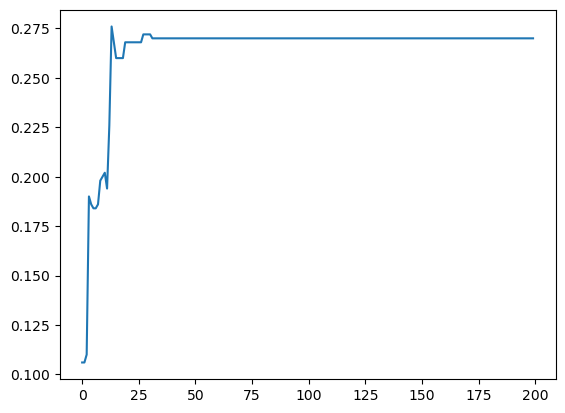

In [12]:
plt.plot(df_performance['A_tr'])

In [13]:
Y_true = torch.concatenate([torch.sin(TINY.X_train_rescale[:, 0, 0, :].sum(dim = -1, keepdim = True)*k) for k in range(1, 11)], dim = 1)

In [14]:
Y_true.shape

torch.Size([500, 10])

In [15]:
Y = torch.nn.functional.one_hot(Y_true.argmax(1)).float()

In [16]:
Y.shape

torch.Size([500, 10])

In [36]:
for i in range(10) :
    print(Y[:, i].mean())

tensor(0.1280)
tensor(0.0860)
tensor(0.1100)
tensor(0.0780)
tensor(0.0800)
tensor(0.0880)
tensor(0.0540)
tensor(0.1140)
tensor(0.1300)
tensor(0.1320)


In [30]:
MLP_model.skeleton

{0: {'size': 10}, 1: {'size': 12}, 2: {'size': 10}, 3: {'size': 10}}